# Posture preprocessing module

This preprocessing module aims to obtain mean sping angle for posture analysis.

## Required Imports

In [85]:
import pandas as pd
import numpy as np

from src.settings import ROOT_DIR
from src.preprocessing.get_anon_id import get_anon_id
from src.utils.data_split import save_and_split

ModuleNotFoundError: No module named 'tensorflow'

## Load Data

In [86]:
data: pd.DataFrame = pd.read_pickle(ROOT_DIR / 'data' / 'processed' / 'anon_imu_data_time_series_cleaned.pkl')

In [87]:
columns_for_posture = ['anon_id', 'date_measure', 'imu_angleY_spine','PD']
posture_data = data[columns_for_posture]
posture_data.head()

,anon_id,date_measure,imu_angleY_spine,PD
0,9,2023-9-29-11-53-21,-548.331774,1
1,9,2023-9-29-11-53-21,-627.825170,1
2,9,2023-9-29-11-53-21,-541.417021,1
3,9,2023-9-29-11-53-21,-584.257673,1
4,9,2023-9-29-11-53-21,-658.587680,1


In [88]:
patientsMds:pd.DataFrame = pd.read_excel(ROOT_DIR / 'data' / 'raw' / 'patients_mdsupdrs_results.xlsx')
patientsMds_used_columns = ['Cédula','Postura']

We calculate the mean Y angle for the spine

In [89]:
mean_posture = posture_data.groupby(['date_measure', 'anon_id','PD'])['imu_angleY_spine'].mean().reset_index()

mean_posture_df = pd.DataFrame(mean_posture)
mean_posture_df.rename(columns={'imu_angleY_spine': 'mean_angleY_spine'}, inplace=True)
mean_posture_df.head()

,date_measure,anon_id,PD,mean_angleY_spine
0,2023-10-5-10-15-58,128,1,-42.485229
1,2023-10-5-10-19-30,129,0,90.612052
2,2023-10-5-10-2-44,34,1,-24.392847
3,2023-10-5-16-14-35,191,0,-37.959155
4,2023-10-5-16-23-50,190,0,-22.743521


In [90]:
print(mean_posture_df['PD'].value_counts())


PD
1    85
0    81
Name: count, dtype: int64


In [91]:
controls_posture_df = mean_posture_df[mean_posture_df['PD'] == 0].copy()

# Imprimir las primeras filas del DataFrame filtrado
print(controls_posture_df.head())

          date_measure anon_id  PD  mean_angleY_spine
1   2023-10-5-10-19-30     129   0          90.612052
3   2023-10-5-16-14-35     191   0         -37.959155
4   2023-10-5-16-23-50     190   0         -22.743521
5    2023-10-5-16-34-4     188   0          13.815587
9  2023-11-30-19-27-32     151   0         -69.065567


In [92]:

patientsMds = patientsMds[patientsMds_used_columns]
patientsMds['anon_id'] = patientsMds['Cédula'].astype(str).apply(get_anon_id)
patientsMds.drop('Cédula', axis=1, inplace=True)

patientsMds.head()


,Postura,anon_id
0,1,11
1,1,87
2,1,32
3,2,27
4,4,78


In [93]:
patientsMds.count()

Postura    90
anon_id    90
dtype: int64

In [94]:
# Realizar la unión por las columnas 'id' y 'anon_id'
merged_df = pd.merge(mean_posture_df, patientsMds, left_on='anon_id', right_on='anon_id', how='inner')

# Eliminar la columna 'anon_id' si no es necesaria en el DataFrame final
#merged_df.drop('anon_id', axis=1, inplace=True)
#id_column = merged_df.pop('id')
#merged_df.insert(1, 'id', id_column)

# Imprimir el DataFrame resultante para verificar
print(merged_df.head())
print(merged_df.columns)

         date_measure anon_id  PD  mean_angleY_spine  Postura
0  2023-10-5-10-15-58     128   1         -42.485229        1
1  2023-2-23-15-52-11     106   1         -11.845045        0
2   2023-9-30-9-14-42     106   1          -1.947670        0
3   2023-3-17-11-1-26      32   1           6.457396        1
4  2023-3-17-11-12-26      27   1         -26.668359        2
Index(['date_measure', 'anon_id', 'PD', 'mean_angleY_spine', 'Postura'], dtype='object')


In [95]:
def classify_row(row):
    if row['PD'] == 1:
        if (row['Postura'] != 0):
            return 1
        else:
            return 0
    elif row['PD'] == 0:
        return 0
    else:
        return np.nan  # Otra clasificación

# Crear una nueva columna 'classification' aplicando la función a cada fila
merged_df['classification'] = merged_df.apply(classify_row, axis=1)

# Imprimir el DataFrame resultante
print(merged_df.head())

         date_measure anon_id  PD  mean_angleY_spine  Postura  classification
0  2023-10-5-10-15-58     128   1         -42.485229        1               1
1  2023-2-23-15-52-11     106   1         -11.845045        0               0
2   2023-9-30-9-14-42     106   1          -1.947670        0               0
3   2023-3-17-11-1-26      32   1           6.457396        1               1
4  2023-3-17-11-12-26      27   1         -26.668359        2               1


In [96]:
columns_to_drop = ['PD','date_measure','anon_id','Postura']

# Eliminar las columnas relacionadas con el temblor del DataFrame
merged_df.drop(columns=columns_to_drop, inplace=True)

# Imprimir el DataFrame resultante
merged_df.head()

,mean_angleY_spine,classification
0,-42.485229,1
1,-11.845045,0
2,-1.947670,0
3,6.457396,1
4,-26.668359,1


In [97]:
columns_to_drop = ['date_measure','anon_id']
controls_posture_df.drop(columns=columns_to_drop, inplace=True)
controls_posture_df.rename(columns={'PD': 'classification'}, inplace=True)
class_column = controls_posture_df.pop('classification')
controls_posture_df.insert(1, 'classification', class_column)

controls_posture_df.head()

,mean_angleY_spine,classification
1,90.612052,0
3,-37.959155,0
4,-22.743521,0
5,13.815587,0
9,-69.065567,0


In [98]:
merged_df = pd.concat([merged_df, controls_posture_df], ignore_index=True)

# Verificar el cambio
print(merged_df.tail())
print(merged_df.columns)

     mean_angleY_spine  classification
140         -11.107275               0
141          -2.679172               0
142         285.358596               0
143          64.860429               0
144        -159.258904               0
Index(['mean_angleY_spine', 'classification'], dtype='object')


In [99]:
print(merged_df['classification'].value_counts())

classification
0    109
1     36
Name: count, dtype: int64


No we make a graph to visualize data

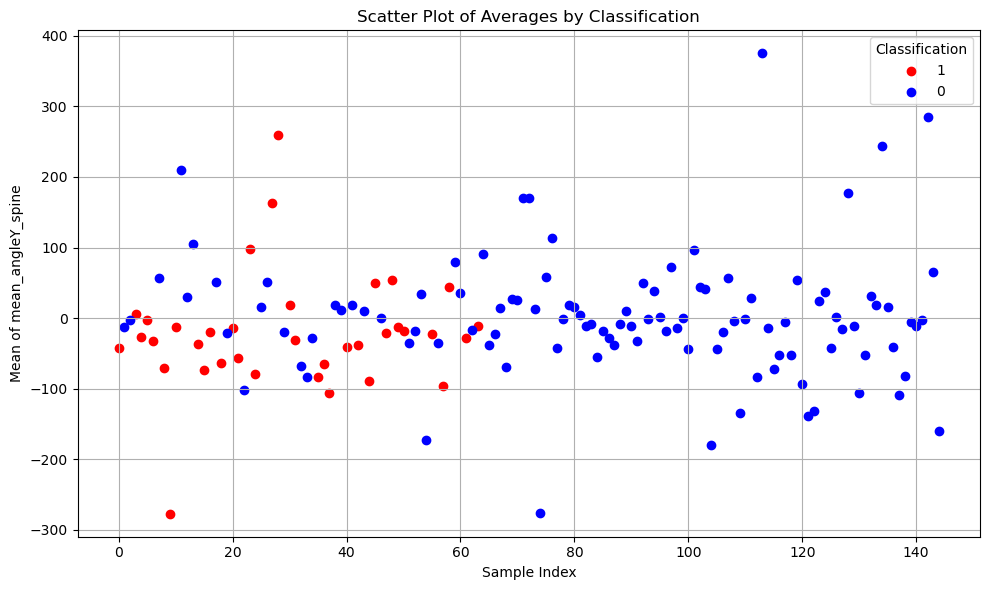

In [100]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Iterate over unique classification classes
for classification, color in zip(merged_df['classification'].unique(), ['red', 'blue']):
    subset_df = merged_df[merged_df['classification'] == classification]
    plt.scatter(subset_df.index, subset_df['mean_angleY_spine'], label=classification, color=color)

plt.xlabel('Sample Index')
plt.ylabel('Mean of mean_angleY_spine')
plt.title('Scatter Plot of Averages by Classification')
plt.legend(title='Classification')
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
save_and_split(merged_df, 'posture')

NameError: name 'save_and_split' is not defined